In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit 

In [7]:
f_psfws = ["size_summary_psfws_df.p", "e1_summary_psfws_df.p", "e2_summary_psfws_df.p"]
f_rand = ["size_summary_rand_df.p", "e1_summary_rand_df.p", "e2_summary_rand_df.p"]
f_randMatch = ["size_summary_randMatch_df.p", "e1_summary_randMatch_df.p", "e2_summary_randMatch_df.p"]
f_randProfile = ["size_summary_randMatchProfile_df.p", "e1_summary_randMatchProfile_df.p", "e2_summary_randMatchProfile_df.p"]
path = "../summariesCircle/"
pathP = "../summariesProfile/"

size_psfws, e1_psfws, e2_psfws = [pickle.load(open(path+f_psfws[i], "rb")) for i in range(3)]
size_rand, e1_rand, e2_rand = [pickle.load(open(path+f_rand[i], "rb")) for i in range(3)]   
size_randMatch, e1_randMatch, e2_randMatch = [pickle.load(open(path+f_randMatch[i], "rb")) for i in range(3)]
size_randProfile, e1_randProfile, e2_randProfile = [pickle.load(open(pathP+f_randProfile[i], "rb")) for i in range(3)]

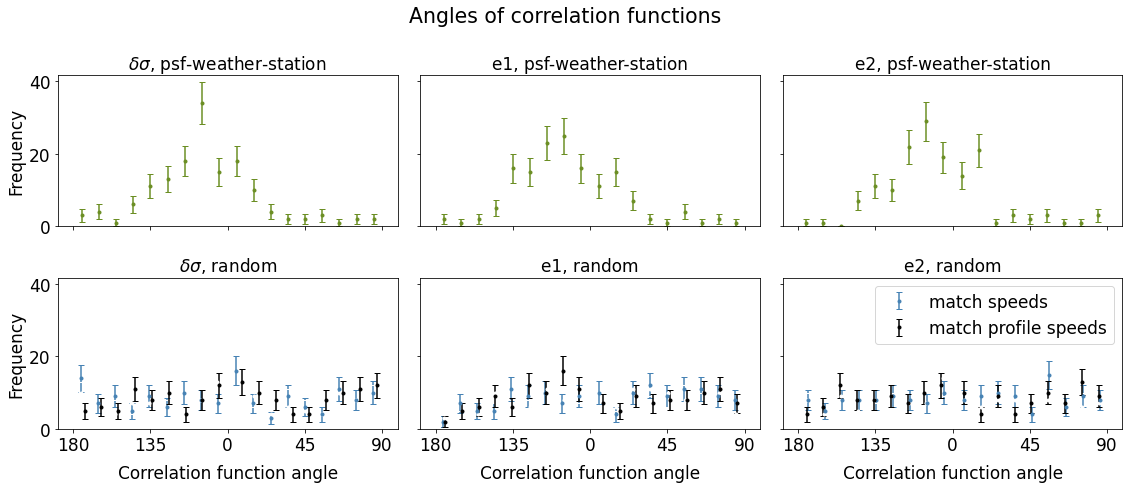

In [15]:
def plothist(ax,para,clr, lbl=""):
    """plot histogram of para as points with poisson uncertainty"""
    y, bin_edges, _ = ax.hist(para, bins=18, histtype='step', color="white")
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    bin_centers = [x+90 if x<90 else x-90 for x in bin_centers]
    ax.errorbar(
        bin_centers,
        y,
        yerr = y**0.5,
        marker = '.', drawstyle="steps-mid",
        linestyle ="",capsize=3, color=clr, label=lbl)
    return ax


def dataAngles(size,e1,e2):
    para = [size['2p_dir'], e1['2p_dir'], e2['2p_dir']]
    return para


def plotAngles(paraP, paraR, paraRM, paraRP, cl="olivedrab"):
    """main function for plotting angles"""
    plt.rcParams['font.size'] = 17
    plt.rcParams['axes.labelsize'] = 17
    plt.rcParams["axes.titlesize"] = 17
    
    fig,ax = plt.subplots(2,3,figsize=(16,7), sharey=True, sharex=True)

    for i in range(3):
        ax[0,i] = plothist(ax[0,i], paraP[i],cl)
        ax[1,i] = plothist(ax[1,i], paraR[i], "white")
        ax[1,i] = plothist(ax[1,i], paraRM[i],"steelblue", lbl="match speeds")
        ax[1,i] = plothist(ax[1,i], paraRP[i],"k", lbl="match profile speeds")

    ax[0,0].set_title("$\delta\sigma$, psf-weather-station")
    ax[1,0].set_title("$\delta\sigma$, random")
    ax[0,1].set_title("e1, psf-weather-station")
    ax[1,1].set_title("e1, random")
    ax[0,2].set_title("e2, psf-weather-station")
    ax[1,2].set_title("e2, random")
    fig.suptitle("Angles of correlation functions")


    [a.set_xlabel("Correlation function angle", labelpad=10) for a in ax[1]]
    [ax[i,0].set_ylabel("Frequency") for i in range(2)]
    ax[0,0].set_xticks(np.linspace(0,180,5))
    ax[0,0].set_xticklabels([180,135,0,45,90])
    ax[1,2].legend()

    fig.tight_layout()
    #plt.savefig("anglesC.pdf")
    
    
    
paraP = dataAngles(size_psfws, e1_psfws, e2_psfws) 
paraR = dataAngles(size_rand, e1_rand, e2_rand)
paraRM = dataAngles(size_randMatch, e1_randMatch, e2_randMatch) 
paraRP = dataAngles(size_randProfile, e1_randProfile, e2_randProfile) 

plotAngles(paraP, paraR, paraRM, paraRP)

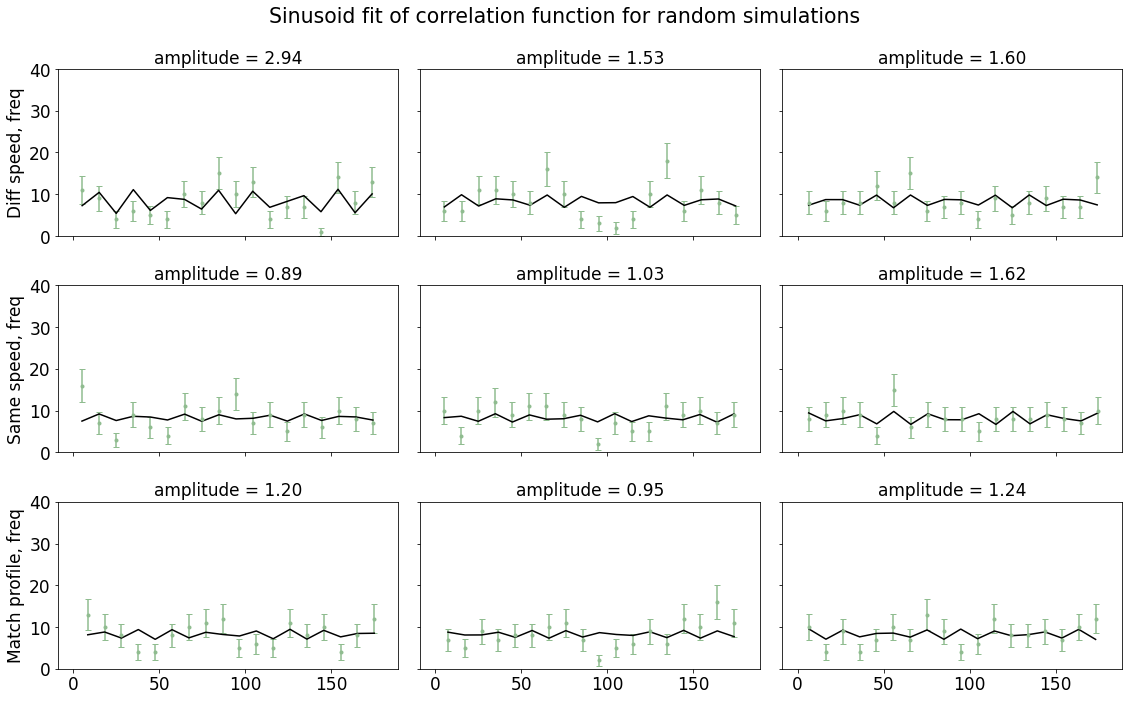

In [16]:
def sine(x,A,B,C):
    return A*np.sin(x+C)+ B

def fit_sine(ax, para):
    y, bin_edges, _ = ax.hist(para, bins=18, histtype='step', label="data", color="white")
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    #bin_centers = [x+90 if x<90 else x-90 for x in bin_centers]
    ax.errorbar(
        bin_centers,
        y,
        yerr = y**0.5,
        marker = '.', drawstyle="steps-mid",
        linestyle ="",capsize=3, color="darkseagreen")
    popt, pcov = curve_fit(sine, bin_centers, y)
    ax.plot(bin_centers, sine(bin_centers,popt[0],popt[1], popt[2]),label="sinusoid fit",color="k")
    ax.set_title(f"amplitude = {abs(popt[0]):.2f}")
    return ax

fig, ax = plt.subplots(3,3,figsize=(16,10), sharex=True,sharey=True)
[fit_sine(ax[0,i],paraR[i]) for i in range(3)]
[fit_sine(ax[1,i],paraRM[i]) for i in range(3)]
[fit_sine(ax[2,i],paraRP[i]) for i in range(3)]

ax[0,0].set_ylabel("Diff speed, freq")
ax[1,0].set_ylabel("Same speed, freq")
ax[2,0].set_ylabel("Match profile, freq")
#ax[1,2].legend(loc='center left', bbox_to_anchor=(1, 1))
ax[0,0].set_ylim(ymax=40)
fig.suptitle("Sinusoid fit of correlation function for random simulations")
fig.tight_layout();

In [20]:
def autoCorr(size, e1, e2): 
    para = [size["autocorr"], e1["autocorr"], e2["autocorr"]]
    return para

autocorrP = autoCorr(size_psfws, e1_psfws, e2_psfws) 
autocorrR = autoCorr(size_rand, e1_rand, e2_rand)
autocorrRM = autoCorr(size_randMatch, e1_randMatch, e2_randMatch) 
autocorrRP = autoCorr(size_randProfile, e1_randProfile, e2_randProfile) 

vars = pd.DataFrame(index=["size", "e1", "e2"])
vars['psfws'] = [np.mean(autocorrP[i]) for i in range(3)]
vars['rand'] = [np.mean(autocorrR[i]) for i in range(3)]
vars['randMatch'] = [np.mean(autocorrRM[i]) for i in range(3)]
vars['randProfile'] = [np.mean(autocorrRP[i]) for i in range(3)]
pd.options.display.float_format = '{:,.6f}'.format
print("2pcf height")
vars

2pcf height


,psfws,rand,randMatch,randProfile
size,0.000064,0.000090,0.000053,0.000053
e1,0.000060,0.000096,0.000054,0.000053
e2,0.000160,0.000203,0.000135,0.000169


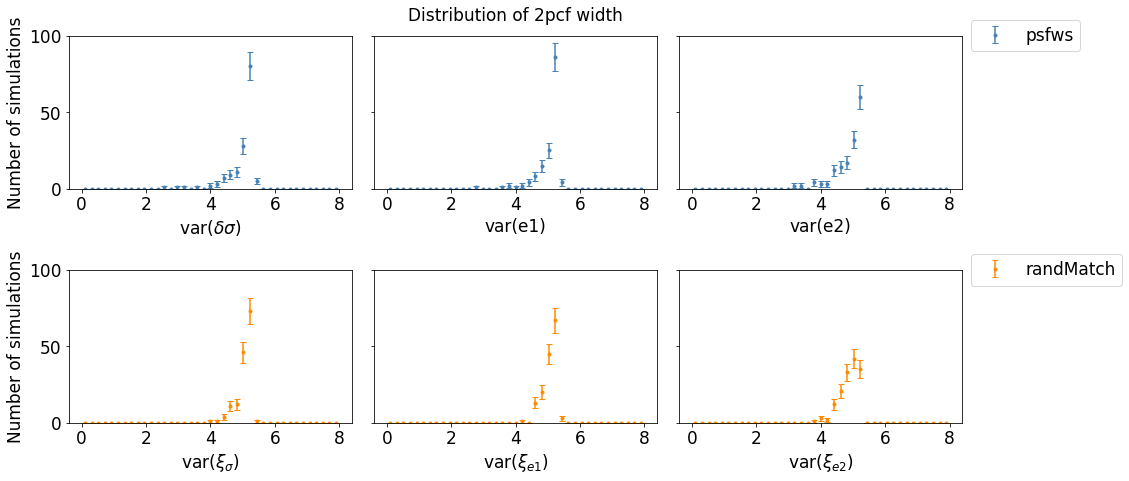

In [77]:
def width2pcf(size, e1, e2): 
    para = [size["2p_sig"], e1["2p_sig"], e2["2p_sig"]]
    return para

width2pcfP = width2pcf(size_psfws, e1_psfws, e2_psfws) 
width2pcfRP = width2pcf(size_randProfile, e1_randProfile, e2_randProfile)
width2pcfRM = width2pcf(size_randMatch, e1_randMatch, e2_randMatch) 

def plothist(ax,para,clr, lbl=""):
    """plot histogram of para as points with poisson uncertainty"""
    y, bin_edges, _ = ax.hist(para, bins=np.linspace(0,8,40), histtype='step', color="white")
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    ax.errorbar(
        bin_centers,
        y,
        yerr = y**0.5,
        marker = '.', drawstyle="steps-mid",
        linestyle ="",capsize=3, color=clr, label=lbl)
    return ax


fig,ax = plt.subplots(2,3,figsize=(16,7), sharey=True)
plt.rcParams['font.size'] = 17
plt.rcParams['axes.labelsize'] = 17
c = ["darksalmon", "olivedrab"]
l = ["rand", "randMatch"]

[plothist(ax[0,i], width2pcfP[i], "steelblue", "psfws") for i in range(3)]
#[plothist(ax[1,i], width2pcfRP[i], "olivedrab", "randProfile") for i in range(3)]
[plothist(ax[1,i], width2pcfRM[i], "darkorange", "randMatch") for i in range(3)]
var_xlbls = ["var($\\delta\\sigma}$)", "var(e1)", "var(e2)"]        
mom_xlbls = ["var($\\xi_{\\sigma}$)", "var($\\xi_{e1}$)", "var($\\xi_{e2}$)"]

[ax[0,i].set_xlabel(var_xlbls[i]) for i in range(3)]
[ax[1,i].set_xlabel(mom_xlbls[i]) for i in range(3)]      
[ax[i,0].set_ylabel("Number of simulations") for i in range(2)]

ax[0,2].legend(loc='center left', bbox_to_anchor=(1, 1)) 
ax[1,2].legend(loc='center left', bbox_to_anchor=(1, 1)) 

ax[0,1].set_title("Distribution of 2pcf width", pad=15)

fig.tight_layout();

''

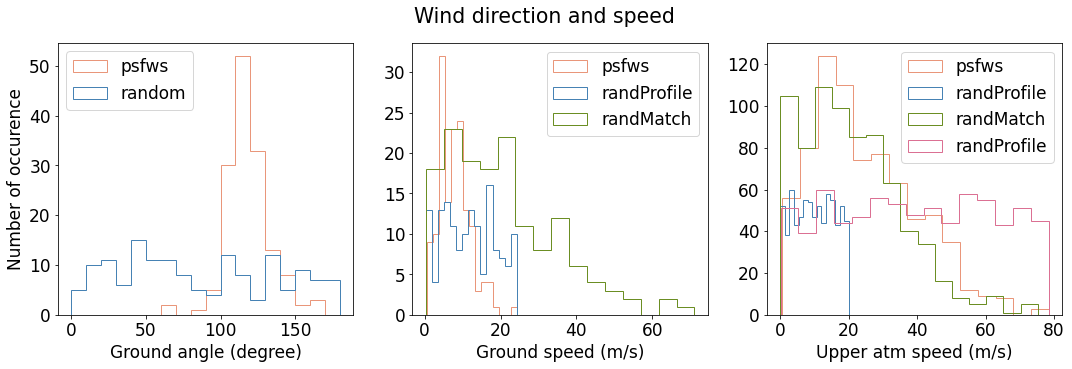

In [76]:
f_atm = ["atm_summary_psfws_df.p", "atm_summary_rand_df.p", "atm_summary_randMatch_df.p"]
atm_psfws, atm_rand, atm_randMatch = [pickle.load(open(path+f_atm[i], "rb")) for i in range(3)]
atm_profile = pickle.load(open(pathP+'atm_summary_randMatchProfile_df.p', 'rb'))

for atm in [atm_psfws, atm_rand, atm_randMatch, atm_profile]:
    atm['dir_0'] = [atm['direction'].iloc[i][0].deg%180 for i in range(len(atm))]
    atm['spd_0'] = [atm['speed'].iloc[i][0] for i in range(len(atm))]

    
def plothist(ax,para,clr,b, lbl=""):
    """plot histogram of para as points with poisson uncertainty"""
    ax.hist(para, bins=b, histtype='step', color=clr, label=lbl)
    return ax

plt.rcParams['font.size'] = 17
plt.rcParams['axes.labelsize'] = 17

# GROUND DIR
fig,ax = plt.subplots(1,3,figsize=(18,5))
ax[0] = plothist(ax[0], atm_psfws["dir_0"],"darksalmon",np.linspace(0,180,19),"psfws") 
ax[0] = plothist(ax[0], atm_rand["dir_0"],"steelblue",np.linspace(0,180,19), "random")

# GROUND SPEED
clr=["darksalmon", "steelblue", "olivedrab","palevioletred"]
lbl = ['psfws', 'randProfile', "randMatch", "randProfile"]
[plothist(ax[1], [atm_psfws, atm_profile, atm_randMatch][i]['spd_0'], clr[i], 15, lbl[i]) for i in range(3)]

ax[0].set_xlabel("Ground angle (degree)")
ax[1].set_xlabel("Ground speed (m/s)")
ax[0].set_ylabel("Number of occurence")

#UPPER ATM SPEED
def get_atmSpd(para):
    seeds = list(range(6, 11)) + [22, 23, 25, 26, 27] + list(range(30, 40))
    seeds += list(range(42, 171))
    a=[]
    for i in seeds:
        [a.append(para["speed"][i][j]) for j in range(1,6)]
    return a
paras = [atm_psfws, atm_rand, atm_randMatch, atm_profile]
atmSpd_psfws, atmSpd_rand, atmSpd_randMatch, atmSpd_profileMatch = [get_atmSpd(paras[i]) for i in range(4)]
[plothist(ax[2], [atmSpd_psfws, atmSpd_rand, atmSpd_randMatch, atmSpd_profileMatch][i], clr[i], 15, lbl[i]) for i in range(4)]
ax[2].set_xlabel("Upper atm speed (m/s)")

ax[0].legend(loc="upper left")
[ax[i].legend() for i in range(1,3)]
fig.suptitle("Wind direction and speed")

;